# 統計學習與深度學習期末報告 第四組 U質同學

### 組員姓名與學號

R09725005 楊雅汝 

R09725008 林聖典 

R09725009 顏煥勳 

R09725011 陳宇鑫 

R09725022 陳君儒 

R09725052 余俊廷

## 研究目標：雙北市租金預測模型

## 一、讀取租屋資料

#### 匯入必要的套件

In [ ]:
%matplotlib inline
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 避免顯示科學記號的設定

In [ ]:
pd.set_option('display.float_format',lambda x : '%.2f' % x)
np.set_printoptions(suppress=True)

#### 從組員(煥勳)的github把**591租屋網雙北民間租屋資料**讀進Google Colab的虛擬機(virtual machine)中

In [ ]:
#!git clone https://github.com/andyyen2529/Rent-Prediction-Model-in-Taipei-City.git

#### 先讀取其中一份資料集(臺北_2018Q3)做測試

In [ ]:
# file_path = './Rent-Prediction-Model-in-Taipei-City/開放台灣民間租屋資料/臺北/'
# print(os.listdir(file_path))
# df = pd.read_excel(file_path + '2018Q3_taipei.csv.xlsx', index_col=0)
# df.head()

#### 讀取所有591租屋網雙北民間租屋資料，並合併成一個大資料集(這一步需要花上一段時間)

In [ ]:
### 這個block嘗試在跑所有檔案直接把這段槓掉就是只跑前面的單檔
"""
file_path = './Rent-Prediction-Model-in-Taipei-City/開放台灣民間租屋資料/臺北/'
df = pd.DataFrame()
for file in os.listdir(file_path):
    print(file)
    current_df = pd.read_excel(file_path + file, index_col=0)
    current_df['資料來源'] = file.split('.')[0]
    df = df.append(current_df)
file_path2 = './Rent-Prediction-Model-in-Taipei-City/開放台灣民間租屋資料/新北/'
for file in os.listdir(file_path2):
    print(file)
    current_df = pd.read_excel(file_path2 + file, index_col=0)
    current_df['資料來源'] = file.split('.')[0]
    df = df.append(current_df)

### 少跑這兩行會快超級多，如果跑出來的結果有多一行，那就再drop index
"""
"""
df = df.reset_index()
df
df.head()
"""

'\ndf = df.reset_index()\ndf\ndf.head()\n'

#### 將數個csv檔合併之後的結果輸出成pickle檔，方便未來讀取

In [ ]:
# df.to_pickle("web591") 

#### 讀取整理後的pickle檔案

In [ ]:
df = pd.read_pickle("web591")

## 二、資料前處理

### 第一階段：針對「資料格式」的處理

#### 資料篩選

In [ ]:
#建物類型選取 0、2、3 （公寓、電梯大樓、華廈），排除透天、工廠農地等
df = df.loc[(df['建築類型'] == 0) | (df['建築類型'] == 2) | (df['建築類型'] == 3)]

#只選取不重複物件→重複之物件視為乏人問津存有偏差值
df = df.loc[df['重複物件數'] == 1]

#有一筆雅房的真的太太太太太太太太太怪了所以也人工清除
df = df.drop(df[(df['物件類型'] == 3) & (df['月租金'] == 130000)].index)

#刪掉只有一筆的坪林
df = df.loc[df['鄉鎮市區'] != 1107]

In [ ]:
df['月租金'].describe()

count     532592.00
mean       23348.55
std       195106.92
min            1.00
25%        10000.00
50%        17000.00
75%        27500.00
max     99999999.00
Name: 月租金, dtype: float64

In [ ]:
sorted(df['月租金'][df['月租金'] < 1000])

[1,
 1,
 1,
 2,
 2,
 3,
 4,
 8,
 11,
 20,
 24,
 26,
 33,
 37,
 45,
 50,
 50,
 70,
 70,
 85,
 90,
 93,
 100,
 250,
 300,
 580]

In [ ]:
sorted(df['月租金'][df['月租金'] > 1000000])

[1100000, 1900000, 99999999, 99999999]

In [ ]:
np.mean(df['月租金']) - 3 * np.std(df['月租金']), np.mean(df['月租金']) + 3 * np.std(df['月租金'])

(-561971.6457494219, 608668.750125755)

In [ ]:
q1 = np.percentile(df['月租金'], 25)
q3 = np.percentile(df['月租金'], 75)
iqr = q3 - q1
(q1 - 1.5 * iqr, q3 + 1.5 * iqr)

(-16250.0, 53750.0)

In [ ]:
target_lower = 1000
target_upper = 150000
df2 = df[(df['月租金'] >= target_lower) & (df['月租金'] <= target_upper)]
df2.shape

(530315, 88)

In [ ]:
features = ['重複物件數','縣市','鄉鎮市區','押金月數','月管理費','需要管理費？','提供車位？','建築類型','物件類型','自報頂加？','所在樓層','建物樓高',
            '坪數','陽台數','衛浴數','房數','客廳數','額外費用_電費？','額外費用_水費？','額外費用_瓦斯？','額外費用_網路？','額外費用_第四台？',
            '附近有_學校？','附近有_公園？','附近有_百貨公司？','附近有_超商？','附近有_傳統市場？','附近有_夜市？','附近有_醫療機構？','附近的捷運站數',
            '附近的公車站數','附近的火車站數','附近的高鐵站數','附近的公共自行車數（實驗中）','有性別限制？','可炊？','可寵？','刊登者類型','提供家具_床？',
            '提供家具_桌子？','提供家具_椅子？','提供家具_電視？','提供家具_熱水器？','提供家具_冷氣？','提供家具_沙發？','提供家具_洗衣機？','提供家具_衣櫃？',
            '提供家具_冰箱？','提供家具_網路？','提供家具_第四台？','提供家具_天然瓦斯？']

df_x = df2[features].copy()
df_y = df2['月租金']

#### 定義資料前處理的函式

以下空值都先當作沒有，因為額外費用房東基本上一定要主動揭露，沒填基本代表沒有  
* 額外費用_電費？
* 額外費用_水費？
* 額外費用_瓦斯？
* 額外費用_網路？
* 額外費用_第四台？ 

以下空值都先當作沒有，因為我們假設如果房屋有提供物件或是附近是否有生活機能，這些東西都是優勢，房東基本上一定會主動揭露，沒填基本代表沒有  
* 附近有_學校？
* 附近有_公園？
* 附近有_百貨公司？
* 附近有_超商？
* 附近有_傳統市場？
* 附近有_夜市？
* 附近有_醫療機構？
* 附近的捷運站數
* 附近的公車站數
* 附近的火車站數
* 附近的高鐵站數
* 附近的公共自行車數（實驗中）
* 可炊？
* 可寵？
* 提供家具_床？
* 提供家具_桌子？
* 提供家具_椅子？
* 提供家具_電視？
* 提供家具_熱水器？
* 提供家具_冷氣？
* 提供家具_沙發？
* 提供家具_洗衣機？
* 提供家具_衣櫃？
* 提供家具_冰箱？
* 提供家具_網路？
* 提供家具_第四台？
* 提供家具_天然瓦斯？
* 提供家具_床？.1
* 提供家具_桌子？.1
* 提供家具_椅子？.1
* 提供家具_電視？.1
* 提供家具_熱水器？.1
* 提供家具_冷氣？.1
* 提供家具_沙發？.1
* 提供家具_洗衣機？.1
* 提供家具_衣櫃？.1
* 提供家具_冰箱？.1
* 提供家具_網路？.1
* 提供家具_第四台？.1
* 提供家具_天然瓦斯？.1  
* 提供車位？
* 押金月數

月管理費沒寫設為0，需要管理費取決於月管理費
* 需要管理費？
* 月管理費

物件類型 對應：  
0	整層住家  
1	獨立套房  
2	分租套房  
3	雅房  
4	車位  
5	其他  
6	倉庫
7	場地  
65535	不明    

衛浴數、房數、客廳數的數量要依照套房、雅房等填值   
獨立套房：陽台0衛浴1客廳0房數1  
分租套房：陽台0衛浴1客廳0房數1   
雅房：陽台0衛浴0客廳0房數1  
* 陽台數
* 衛浴數
* 房數
* 客廳數

不須額外處理的欄位：
* 刊登者類型  
* 有性別限制？
* 重複物件數
* 縣市
* 鄉鎮市區
* 自報頂加？
* 建築類型
* 物件類型
* 所在樓層
* 建物樓高
* 坪數

In [ ]:
def preprocess(x,y):
  # 以下空值都先當作沒有，因為我們假設如果房屋有提供物件或是附近是否有生活機能，這些東西都是優勢，房東基本上一定會主動揭露，沒填基本代表沒有
  # 以下空值都先當作沒有，因為額外費用房東基本上一定要主動揭露，沒填基本代表沒有

  # 還沒研究為啥有些檔後面會有 .1 目前先把它槓掉
  # features_to_f = ['額外費用_電費？','額外費用_水費？','額外費用_瓦斯？','額外費用_網路？','額外費用_第四台？',
  #           '附近有_學校？','附近有_公園？','附近有_百貨公司？','附近有_超商？','附近有_傳統市場？','附近有_夜市？','附近有_醫療機構？','可炊？','可寵？','提供家具_床？',
  #           '提供家具_桌子？','提供家具_椅子？','提供家具_電視？','提供家具_熱水器？','提供家具_冷氣？','提供家具_沙發？','提供家具_洗衣機？','提供家具_衣櫃？',
  #           '提供家具_冰箱？','提供家具_網路？','提供家具_第四台？','提供家具_天然瓦斯？','提供家具_床？.1','提供家具_桌子？.1','提供家具_椅子？.1','提供家具_電視？.1',
  #           '提供家具_熱水器？.1','提供家具_冷氣？.1','提供家具_沙發？.1','提供家具_洗衣機？.1','提供家具_衣櫃？.1','提供家具_冰箱？.1','提供家具_網路？.1',
  #           '提供家具_第四台？.1','提供家具_天然瓦斯？.1','提供車位？']
    features_to_f = ['額外費用_電費？','額外費用_水費？','額外費用_瓦斯？','額外費用_網路？','額外費用_第四台？',
            '附近有_學校？','附近有_公園？','附近有_百貨公司？','附近有_超商？','附近有_傳統市場？','附近有_夜市？','附近有_醫療機構？','可炊？','可寵？','提供家具_床？',
            '提供家具_桌子？','提供家具_椅子？','提供家具_電視？','提供家具_熱水器？','提供家具_冷氣？','提供家具_沙發？','提供家具_洗衣機？','提供家具_衣櫃？',
            '提供家具_冰箱？','提供家具_網路？','提供家具_第四台？','提供家具_天然瓦斯？','提供車位？']

    features_to_zero = ['附近的捷運站數','附近的公車站數','附近的火車站數','附近的高鐵站數',
            '附近的公共自行車數（實驗中）', '押金月數']

    x.loc[:,features_to_f] = x.loc[:,features_to_f].replace("-", np.nan)
    x.loc[:,features_to_f] = x.loc[:,features_to_f].fillna('F')

    x.loc[:,features_to_zero] = x.loc[:,features_to_zero].replace("-", np.nan)
    x.loc[:,features_to_zero] = x.loc[:,features_to_zero].fillna(0)

    # 月管理費沒寫設為0，需要管理費取決於月管理費
    x.loc[:,'月管理費'] = x.loc[:,'月管理費'].replace("-", np.nan)
    x.loc[:,'月管理費'] = x.loc[:,'月管理費'].fillna(0)
    x.loc[(x['需要管理費？']=='-') & (x['月管理費']==0),'需要管理費？'] = "F"
    
    ### 這段我跑起來會壞掉，它說月管理費欄位裡有str，但我看明明就沒有阿...
    x.loc[(x['需要管理費？']=='-') & (x['月管理費']!=0),'需要管理費？'] = "T"

#     1 獨立套房
#     2 分租套房
#     3 雅房
    # 依照物件類型處理陽台、衛浴等
    x.loc[(x['陽台數']=='-') & (x['物件類型'] == 1),'陽台數'] = 0
    x.loc[x['物件類型'] == 1,'衛浴數'] = 1
    x.loc[(x['客廳數']=='-') & (x['物件類型'] == 1),'客廳數'] = 0
    x.loc[(x['物件類型'] == 1),'房數'] = 1
    x.loc[(x['陽台數']=='-') & (x['物件類型'] == 2),'陽台數'] = 0
    x.loc[(x['物件類型'] == 2),'衛浴數'] = 1
    x.loc[(x['客廳數']=='-') & (x['物件類型'] == 2),'客廳數'] = 0
    x.loc[(x['物件類型'] == 2),'房數'] = 1
    x.loc[(x['陽台數']=='-') & (x['物件類型'] == 3),'陽台數'] = 0
    x.loc[(x['物件類型'] == 3),'衛浴數'] = 0
    x.loc[(x['客廳數']=='-') & (x['物件類型'] == 3),'客廳數'] = 0
    x.loc[(x['物件類型'] == 3),'房數'] = 1
    ### 還是會有少數的資料是空白的，目前先刪掉
    delete_num = len(x[x['房數']=='-'].index)
    indexs = x[x['房數']=='-'].index
    x = x.drop(indexs)
    y = y.drop(indexs)
    print("共有{}筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了".format(delete_num))

    ### 砍掉整層住家房間數為零者
    delete_num = len(x[(x['物件類型'] == 0) & (x['房數']==0)].index)
    indexs = x[(x['物件類型'] == 0) & (x['房數']==0)].index
    x = x.drop(indexs)
    y = y.drop(indexs)
    print("共有{}筆資料房數是0的，所以先刪了".format(delete_num))

    ### 砍掉整層住家衛浴數為零為零者
    delete_num = len(x[(x['物件類型'] == 0) & (x['衛浴數']==0)].index)
    indexs = x[(x['物件類型'] == 0) & (x['衛浴數']==0)].index
    x = x.drop(indexs)
    y = y.drop(indexs)
    print("共有{}筆資料衛浴數是0的，所以先刪了".format(delete_num))
    ### 砍掉重複刊登次數 > 2 的: 上面已砍
    #index_dup = x[x['重複物件數'] > 1].index
    #x = x.drop(index_dup)
    #y = y.drop(index_dup)
    #print("共有{}筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了".format(delete_num))

    # 將T/F轉為1/0
    x = x.replace('T', 1)
    x = x.replace('F', 0)

    if '-' in x.values:
        print('還有空值存在dataframe中，請檢查!!!!')
        print("前處理完成")
    return x, y

#### 實施資料前處理

In [ ]:
df_x, df_y = preprocess(df_x, df_y)

共有48筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了
共有4144筆資料房數是0的，所以先刪了
共有310筆資料衛浴數是0的，所以先刪了


<ipython-input-25-f01f67baec05>:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in x.values:


#### 切分訓練集和測試集

In [ ]:
from sklearn.model_selection import train_test_split

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split( df_x, df_y, test_size=0.25, random_state=4)

#### 查看處理後的資料 + 其他細節處理

In [ ]:
df_train_x.head()

,重複物件數,縣市,鄉鎮市區,押金月數,月管理費,需要管理費？,提供車位？,建築類型,物件類型,自報頂加？,...,提供家具_電視？,提供家具_熱水器？,提供家具_冷氣？,提供家具_沙發？,提供家具_洗衣機？,提供家具_衣櫃？,提供家具_冰箱？,提供家具_網路？,提供家具_第四台？,提供家具_天然瓦斯？
503166,1,11,1111,2.00,0.00,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
605085,1,11,1117,2.00,0.00,0,0,2,0,0,...,0,1,1,1,1,1,1,0,0,1
7634,1,17,1700,0.00,0.00,0,0,2,2,0,...,1,1,1,1,1,1,1,0,1,1
223418,1,17,1701,2.00,0.00,0,0,0,2,0,...,1,1,1,1,1,1,1,1,0,0
452243,1,11,1111,2.00,0.00,0,0,2,0,0,...,0,1,1,1,1,1,1,0,0,1


In [ ]:
df_train_y.head()

503166    12900
605085    19000
7634      15800
223418    12700
452243    18000
Name: 月租金, dtype: int64

In [ ]:
train_in = df_train_x['鄉鎮市區'].unique()

In [ ]:
df_test_x[df_test_x['鄉鎮市區'].isin(train_in) == False]

,重複物件數,縣市,鄉鎮市區,押金月數,月管理費,需要管理費？,提供車位？,建築類型,物件類型,自報頂加？,...,提供家具_電視？,提供家具_熱水器？,提供家具_冷氣？,提供家具_沙發？,提供家具_洗衣機？,提供家具_衣櫃？,提供家具_冰箱？,提供家具_網路？,提供家具_第四台？,提供家具_天然瓦斯？


In [ ]:
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

<AxesSubplot:>

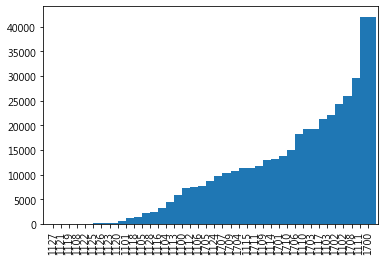

In [ ]:
df_train_x['鄉鎮市區'].value_counts().sort_values().plot(kind='bar', width=2)

<AxesSubplot:>

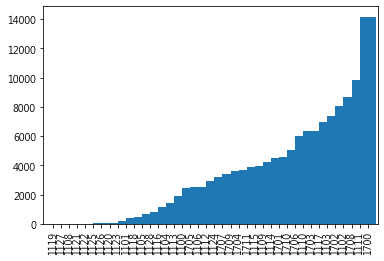

In [ ]:
df_test_x['鄉鎮市區'].value_counts().sort_values().plot(kind='bar', width=2)

In [ ]:
ratio = pd.concat([(df_train_x['鄉鎮市區'].value_counts()/df_train_x.shape[0]).sort_values().reset_index(),(df_test_x['鄉鎮市區'].value_counts()/df_test_x.shape[0]).sort_values().reset_index()], axis = 1)

In [ ]:
#分布大致相同 <- 之後會再改，總之先拿來跑模型XD
ratio

,index,鄉鎮市區,index,鄉鎮市區
0,1127,0.00,1119,0.00
1,1121,0.00,1127,0.00
2,1119,0.00,1108,0.00
3,1108,0.00,1121,0.00
4,1122,0.00,1122,0.00
5,1125,0.00,1125,0.00
6,1126,0.00,1126,0.00
7,1123,0.00,1120,0.00
8,1120,0.00,1123,0.00
9,1101,0.00,1101,0.00


In [ ]:
x_train = df_train_x.reset_index(drop=True)
x_test = df_test_x.reset_index(drop=True)
x_train.head()

,重複物件數,縣市,鄉鎮市區,押金月數,月管理費,需要管理費？,提供車位？,建築類型,物件類型,自報頂加？,...,提供家具_電視？,提供家具_熱水器？,提供家具_冷氣？,提供家具_沙發？,提供家具_洗衣機？,提供家具_衣櫃？,提供家具_冰箱？,提供家具_網路？,提供家具_第四台？,提供家具_天然瓦斯？
0,1,11,1111,2.00,0.00,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
1,1,11,1117,2.00,0.00,0,0,2,0,0,...,0,1,1,1,1,1,1,0,0,1
2,1,17,1700,0.00,0.00,0,0,2,2,0,...,1,1,1,1,1,1,1,0,1,1
3,1,17,1701,2.00,0.00,0,0,0,2,0,...,1,1,1,1,1,1,1,1,0,0
4,1,11,1111,2.00,0.00,0,0,2,0,0,...,0,1,1,1,1,1,1,0,0,1


In [ ]:
y_train = df_train_y
y_test = df_test_y

In [ ]:
# 保留 分租套房、獨立套房、雅房、整層住家的index
isuite_index = x_train.loc[(x_train['物件類型']==1)].index  # 獨立套房
dsuite_index = x_train.loc[(x_train['物件類型']==2)].index  # 分租套房
room_index = x_train.loc[(x_train['物件類型']==3)].index    # 雅房
floor_index = x_train.loc[(x_train['物件類型']==0)].index   # 整層住家

isuite_index_test = x_test.loc[(x_test['物件類型']==1)].index  # 獨立套房
dsuite_index_test = x_test.loc[(x_test['物件類型']==2)].index  # 分租套房
room_index_test = x_test.loc[(x_test['物件類型']==3)].index    # 雅房
floor_index_test = x_test.loc[(x_test['物件類型']==0)].index   # 整層住家

### 第二階段：針對提升模型收斂效率和測試集預測能力的處理

#### (1) 特徵縮放(Feature Scaling)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
# x_train_std = scaler.fit_transform(x_train)

enc = OneHotEncoder(handle_unknown='ignore')


#這邊做了一些更改
#有鄉鎮市區就不需要縣市欄位
#把電梯丟進去暫時不考慮大樓華廈與公寓的差異

con_features = ['重複物件數','押金月數','所在樓層','建物樓高','坪數',
                '陽台數','衛浴數','房數','客廳數','附近的捷運站數','附近的公車站數',
       '附近的火車站數','附近的高鐵站數','附近的公共自行車數（實驗中）']
cat_features = ['鄉鎮市區','物件類型','刊登者類型'] 


x_train_con = x_train[con_features]
x_train_cat = x_train[cat_features]

x_train_con_std = scaler.fit_transform(x_train_con)
x_train_cat_one_hot = enc.fit_transform(x_train_cat).toarray()

gg = con_features + cat_features
print(len(gg))
x_train_remain = x_train.drop(gg, axis=1)
#x_train_remain <- 跑這行我的電腦會當機，讓我先暫時拿掉XD (by君儒)
x_train_std = x_train_remain.join(pd.DataFrame(x_train_con_std, columns=con_features))
x_train_std = x_train_std.join(pd.DataFrame(x_train_cat_one_hot, columns = enc.get_feature_names()))
#x_train_std
# pd.get_dummies(x_train) 需要資料裡面是真的類別，而非17、11這樣的數字，所以用OneHotEncoder


17


In [ ]:
x_train_cat_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# test OneHot
x_test_con = x_test[con_features]
x_test_cat = x_test[cat_features]

# 都只要transform就好
x_test_con_std = scaler.transform(x_test_con)
x_test_cat_one_hot = enc.transform(x_test_cat).toarray()

x_test_remain = x_test.drop(gg,axis=1)
#x_test_remain
x_test_std = x_test_remain.join(pd.DataFrame(x_test_con_std, columns=con_features))
x_test_std = x_test_std.join(pd.DataFrame(x_test_cat_one_hot, columns = enc.get_feature_names()))
#x_test_std

In [ ]:
#最後再篩一下數據
#縣市刪除
#管理費移除
#重複物件數移除\
x_train_std = x_train_std.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test_std = x_test_std.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)

x_train = x_train.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test = x_test.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)

In [ ]:
x_train_std.columns

Index(['月管理費', '提供車位？', '建築類型', '自報頂加？', '額外費用_電費？', '額外費用_水費？', '額外費用_瓦斯？',
       '額外費用_網路？', '額外費用_第四台？', '附近有_學校？', '附近有_公園？', '附近有_百貨公司？', '附近有_超商？',
       '附近有_傳統市場？', '附近有_夜市？', '附近有_醫療機構？', '有性別限制？', '可炊？', '可寵？', '提供家具_床？',
       '提供家具_桌子？', '提供家具_椅子？', '提供家具_電視？', '提供家具_熱水器？', '提供家具_冷氣？', '提供家具_沙發？',
       '提供家具_洗衣機？', '提供家具_衣櫃？', '提供家具_冰箱？', '提供家具_網路？', '提供家具_第四台？',
       '提供家具_天然瓦斯？', '押金月數', '所在樓層', '建物樓高', '坪數', '陽台數', '衛浴數', '房數', '客廳數',
       '附近的捷運站數', '附近的公車站數', '附近的火車站數', '附近的高鐵站數', '附近的公共自行車數（實驗中）', 'x0_1100',
       'x0_1101', 'x0_1102', 'x0_1103', 'x0_1104', 'x0_1105', 'x0_1106',
       'x0_1108', 'x0_1109', 'x0_1110', 'x0_1111', 'x0_1112', 'x0_1113',
       'x0_1114', 'x0_1115', 'x0_1116', 'x0_1117', 'x0_1118', 'x0_1119',
       'x0_1120', 'x0_1121', 'x0_1122', 'x0_1123', 'x0_1124', 'x0_1125',
       'x0_1126', 'x0_1127', 'x0_1128', 'x0_1700', 'x0_1701', 'x0_1702',
       'x0_1703', 'x0_1704', 'x0_1705', 'x0_1706', 'x0_1707', 'x0_1708',
       'x0_1709', 'x0

## 三、用訓練集開始建立租金預測迴歸模型，之後對測試集進行預測

### 簡單線性迴歸模型-lasso

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
model = LinearRegression()
#model = linear_model.Lasso(alpha=0.1)
model.fit(np.asarray(x_train_std), y_train)
print('intercept:',model.intercept_)
print('coefficient:',model.coef_)
print(f'R-squared of training set: {model.score(np.asarray(x_train_std), y_train): .4f}')

intercept: 11935.7299468187
coefficient: [     1.70558256   2675.06303559    934.61084706  -2107.19344465
  -1024.07692367    175.97018598   1085.12201496   -651.98150703
   -290.19184678    209.52560777   -776.93324368    332.91758322
    553.71145372   -181.04464174   -569.27287332     66.87474916
   -728.94753386     51.82003695   -656.79188318   -435.15061021
     -6.77556191    344.69604654   2334.85303484  -1194.18232046
     36.41197638   1133.11811748   1264.42317346    898.40256482
   1216.90217766    195.59631717   -276.95281069    276.48141892
   -224.67757041    -32.83545631    801.74070428  10614.83748093
    -80.53110773   1407.4780165    -549.98206207    299.56636036
    348.25586505   -297.94739082   -163.72531499      0.
     30.08636274  -5895.96141537 -10501.01730056   2242.06070667
   1516.98176357  -2440.8971456   -6437.9739995    -450.95114605
  -1249.92894502    938.10738642   -744.98169614   2364.6234953
  -4631.32179243  -2348.78770182   3176.45152735  -1450.61

In [ ]:
y_test_pred = model.predict(np.asarray(x_test_std))
print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')

y_compare = pd.DataFrame({'y_pred': y_test_pred,'y_true': y_test})

MAE of testing set: 5187.558279358079
RMSE of testing set: 8440.775025150377


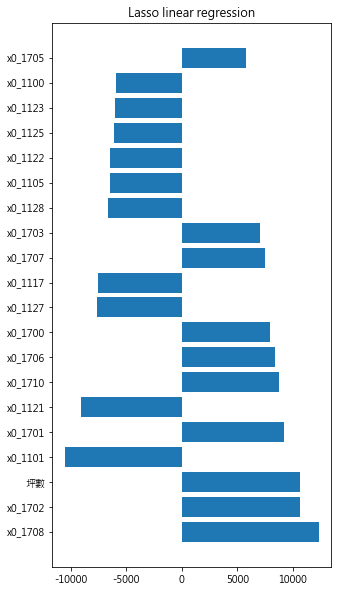

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

importance = model.coef_
abs_importance = abs(importance)
feature_name = list(x_train_std.columns.copy())

feature = []
for i in x_train_std.columns:
    feature.append(str(i))


feature = []
for i in x_train_std.columns:
    feature.append(str(i))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("Lasso linear regression")
plt.barh(np.array(feature)[np.argsort(-abs_importance)[:20]], importance[np.argsort(-abs_importance)][0:20] )
# plt.show()
plt.savefig('Lasso_linear_regression_3.png')
plt.show()

### 簡單線性迴歸模型-Ridge

**版本一：基本版**

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
clf = Ridge(alpha=1.0)
clf.fit(np.asarray(x_train_std), y_train)
print('intercept:',clf.intercept_)
print('coefficient:',clf.coef_)
print(f'R-squared of training set: {clf.score(np.asarray(x_train_std), y_train): .4f}')

intercept: 12029.843101946526
coefficient: [     1.70569259   2674.59508213    934.61626867  -2106.81939885
  -1023.88986059    175.82246822   1085.05447795   -652.17520838
   -290.10658272    209.38369858   -776.88919905    333.20200433
    553.54629017   -180.90923543   -569.183125       66.9506016
   -728.75795061     51.75590553   -656.87752652   -435.33354289
     -6.91552584    344.66785899   2334.95341666  -1194.04547775
     36.99531309   1133.14203965   1264.50956612    898.45021168
   1216.92852804    195.63489554   -277.05827223    276.88574625
   -224.71366877    -32.84848454    801.67531328  10614.73227656
    -80.64111728   1407.45663576   -549.94915344    299.67947555
    348.52899702   -297.99963589   -163.76073556      0.
     30.09049244  -5989.17570314 -10578.04455696   2147.15539106
   1422.12499361  -2534.32790429  -6527.39217926   -545.49286123
  -1209.49243961    843.33318785   -839.56261914   2269.75844151
  -4725.20976574  -2442.54865262   3081.29091225  -1544.

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
y_test_pred = clf.predict(np.asarray(x_test_std))
print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')
y_compare = pd.DataFrame({'y_pred': y_test_pred,'y_true': y_test})
y_compare

MAE of testing set: 5187.497977922497
RMSE of testing set: 8440.812147593993


,y_pred,y_true
97205,29878.44,23500
674857,-4060.88,5000
413487,3587.11,7000
104973,14055.54,14000
698905,28106.12,22000
...,...,...
109782,24478.19,26000
574194,21504.34,20000
524433,4390.13,5500
469983,4899.28,6000


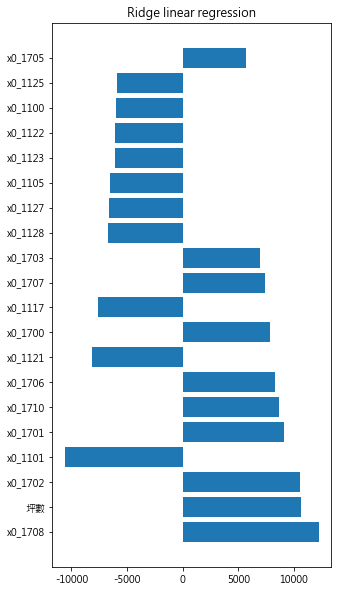

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

importance = clf.coef_
abs_importance = abs(importance)
feature_name = list(x_train_std.columns.copy())

feature = []
for i in x_train_std.columns:
    feature.append(str(i))


feature = []
for i in x_train_std.columns:
    feature.append(str(i))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("Ridge linear regression")
plt.barh(np.array(feature)[np.argsort(-abs_importance)[:20]], importance[np.argsort(-abs_importance)][0:20] )
# plt.show()
plt.savefig('Ridge_linear_regression_3.png')
plt.show()

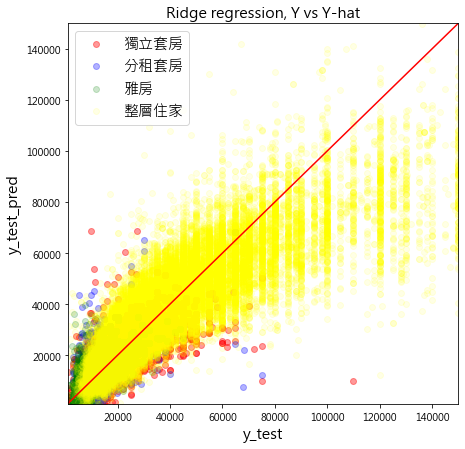

In [ ]:
# 45度線圖
# 做出四種物件的x_test、y_test
x_test_isuite = x_test_std.loc[isuite_index_test]
x_test_dsuite = x_test_std.loc[dsuite_index_test]
x_test_room = x_test_std.loc[room_index_test]
x_test_floor = x_test_std.loc[floor_index_test]

y_test_1 = y_test.reset_index(drop=True)
y_test_isuite = y_test_1[isuite_index_test]
y_test_dsuite = y_test_1[dsuite_index_test]
y_test_room = y_test_1[room_index_test]
y_test_floor = y_test_1[floor_index_test]

y_test_pred_isuite = clf.predict(np.asarray(x_test_isuite))
y_test_pred_dsuite = clf.predict(np.asarray(x_test_dsuite))
y_test_pred_room = clf.predict(np.asarray(x_test_room))
y_test_pred_floor = clf.predict(np.asarray(x_test_floor))

# 繪圖
plt.figure(figsize=(7,7))
plt.scatter(y_test_isuite, y_test_pred_isuite, alpha=0.4, color='red', label="獨立套房")
plt.scatter(y_test_dsuite, y_test_pred_dsuite, alpha=0.3, color='blue', label="分租套房")
plt.scatter(y_test_room, y_test_pred_room, alpha=0.2, color='green', label="雅房")
plt.scatter(y_test_floor, y_test_pred_floor, alpha=0.1, color='yellow', label="整層住家")
plt.axline([min(y_test), min(y_test)], [max(y_test), max(y_test)], color='r')

plt.xlim(min(y_test), max(y_test))
plt.ylim(min(y_test), max(y_test))

plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_test_pred", fontsize=15)
plt.title("Ridge regression, Y vs Y-hat", fontsize=15)
plt.legend(fontsize=15)
plt.show()

#### 版本二：對房租取log(預測效果看起來更好)

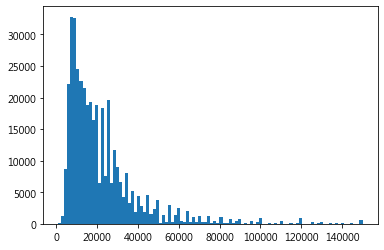

In [ ]:
plt.hist(y_train, bins = 100)
plt.show()

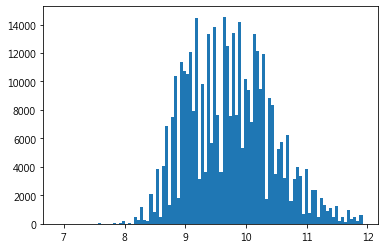

In [ ]:
plt.hist(np.log(y_train), bins = 100)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
#model = linear_model.Lasso(alpha=0.1)
model.fit(np.asarray(x_train_std), np.log(y_train))
print('intercept:',model.intercept_)
print('coefficient:',model.coef_)
print(f'R-squared of training set: {model.score(np.asarray(x_train_std), np.log(y_train)): .4f}')

intercept: 9.131286932029258
coefficient: [ 0.00001504  0.0803673   0.07198192 -0.1152475  -0.02273779  0.01165607
  0.03996067 -0.01084725 -0.0202489  -0.00660719  0.0005975   0.01077223
  0.00878233 -0.00319384 -0.02221983  0.00413671 -0.06257021  0.10446748
 -0.02419833 -0.06779764 -0.01752312  0.00086506  0.06135433 -0.03859832
  0.04134829  0.15037061  0.02234946  0.00520936  0.00763501 -0.0201324
 -0.00580289  0.02995468  0.00219738 -0.00369569  0.05363915  0.24641044
 -0.00479857  0.01771844  0.02527163  0.03658257  0.01494743 -0.00687944
 -0.00286354 -0.          0.00351448 -0.23277897 -0.71131723  0.14137683
  0.11747938 -0.03994072 -0.22839126 -0.00628926 -0.07050249  0.12308026
  0.02740407  0.14114051 -0.05193166 -0.09802632  0.19117378 -0.00588158
 -0.08338082 -0.31779336 -0.06292147  0.00576533 -0.3830549  -0.42109041
 -0.64244904 -0.4919676   0.1288711  -0.54243609 -0.31885217 -0.55967511
 -0.29689761  0.41562662  0.45828878  0.49910442  0.37666539  0.26941401
  0.319932

In [ ]:
y_test_pred = model.predict(np.asarray(x_test_std))
print(f'MAE of testing set: {mean_absolute_error(np.exp(y_test_pred), y_test)}')
y_compare = pd.DataFrame({'y_pred': np.exp(y_test_pred),'y_true': y_test})
y_compare

MAE of testing set: 4215.688349240349


,y_pred,y_true
97205,23865.19,23500
674857,4564.61,5000
413487,6621.42,7000
104973,16068.82,14000
698905,28318.86,22000
...,...,...
109782,25476.40,26000
574194,19185.59,20000
524433,5739.94,5500
469983,7566.31,6000


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error

y_test_pred = model.predict(np.asarray(x_test_std))
print(f'MAE of testing set: {mean_absolute_error(np.exp(y_test_pred), y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(np.exp(y_test_pred), y_test))}')
y_compare = pd.DataFrame({'y_pred': np.exp(y_test_pred),'y_true': y_test})


MAE of testing set: 4215.688349240349
RMSE of testing set: 8849.255623218225


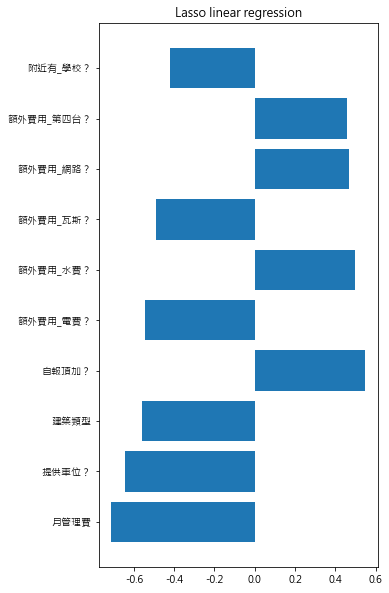

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

importance = model.coef_
abs_importance = abs(importance)
feature_name = list(x_train_std.columns.copy())

feature = []
for i in x_train_std.columns:
    feature.append(str(i))

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("Lasso linear regression")
plt.barh(feature[0:10], importance[np.argsort(-abs_importance)][0:10] )
# plt.show()
plt.savefig('Lasso_linear_regression.png')
plt.show()

#### 版本三：類別變數做獨熱編碼、連續變數做標準化。

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
model = LinearRegression()
# model = Lasso(alpha=0.005)
# model = Ridge(alpha=0.05)
model.fit(np.asarray(x_train_std), np.log(y_train))
print('intercept:',model.intercept_)
print('coefficient:',model.coef_)
print(f'R-squared of training set: {model.score(np.asarray(x_train_std), np.log(y_train)): .4f}')

intercept: 9.131286932029258
coefficient: [ 0.00001504  0.0803673   0.07198192 -0.1152475  -0.02273779  0.01165607
  0.03996067 -0.01084725 -0.0202489  -0.00660719  0.0005975   0.01077223
  0.00878233 -0.00319384 -0.02221983  0.00413671 -0.06257021  0.10446748
 -0.02419833 -0.06779764 -0.01752312  0.00086506  0.06135433 -0.03859832
  0.04134829  0.15037061  0.02234946  0.00520936  0.00763501 -0.0201324
 -0.00580289  0.02995468  0.00219738 -0.00369569  0.05363915  0.24641044
 -0.00479857  0.01771844  0.02527163  0.03658257  0.01494743 -0.00687944
 -0.00286354 -0.          0.00351448 -0.23277897 -0.71131723  0.14137683
  0.11747938 -0.03994072 -0.22839126 -0.00628926 -0.07050249  0.12308026
  0.02740407  0.14114051 -0.05193166 -0.09802632  0.19117378 -0.00588158
 -0.08338082 -0.31779336 -0.06292147  0.00576533 -0.3830549  -0.42109041
 -0.64244904 -0.4919676   0.1288711  -0.54243609 -0.31885217 -0.55967511
 -0.29689761  0.41562662  0.45828878  0.49910442  0.37666539  0.26941401
  0.319932

In [ ]:
# x_test_std = scaler.transform(x_test)
y_test_pred = model.predict(np.asarray(x_test_std))
print(f'MAE of testing set: {mean_absolute_error(np.exp(y_test_pred), y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(np.exp(y_test_pred), y_test))}')
y_compare = pd.DataFrame({'y_pred': np.exp(y_test_pred),'y_true': y_test})
y_compare

MAE of testing set: 4215.688349240349
RMSE of testing set: 8849.255623218225


,y_pred,y_true
97205,23865.19,23500
674857,4564.61,5000
413487,6621.42,7000
104973,16068.82,14000
698905,28318.86,22000
...,...,...
109782,25476.40,26000
574194,19185.59,20000
524433,5739.94,5500
469983,7566.31,6000


In [ ]:
x_train

,鄉鎮市區,押金月數,月管理費,提供車位？,建築類型,物件類型,自報頂加？,所在樓層,建物樓高,坪數,...,提供家具_電視？,提供家具_熱水器？,提供家具_冷氣？,提供家具_沙發？,提供家具_洗衣機？,提供家具_衣櫃？,提供家具_冰箱？,提供家具_網路？,提供家具_第四台？,提供家具_天然瓦斯？
0,1111,2.00,0.00,0,0,0,0,3,4,23.30,...,0,1,1,0,0,1,0,0,0,0
1,1117,2.00,0.00,0,2,0,0,19,26,23.00,...,0,1,1,1,1,1,1,0,0,1
2,1700,0.00,0.00,0,2,2,0,7,8,9.00,...,1,1,1,1,1,1,1,0,1,1
3,1701,2.00,0.00,0,0,2,0,3,5,6.00,...,1,1,1,1,1,1,1,1,0,0
4,1111,2.00,0.00,0,2,0,0,7,9,24.29,...,0,1,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394354,1114,2.00,0.00,0,0,0,0,3,5,36.30,...,0,0,0,0,0,0,0,0,0,0
394355,1700,2.00,0.00,0,2,1,0,6,14,24.92,...,1,1,1,1,1,1,1,1,1,0
394356,1708,2.00,0.00,0,0,0,0,4,4,17.00,...,1,1,1,1,1,1,1,1,1,0
394357,1111,2.00,1277.00,0,2,0,0,8,13,13.44,...,1,1,1,1,1,1,1,0,0,0


### Regression Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)
regressor.fit(np.asarray(x_train), y_train)
y_test_pred = regressor.predict(np.asarray(x_test))
print('feature importances:',regressor.feature_importances_)
# print('coefficient:',regressor.coef_)
print(f'R-squared of training set: {regressor.score(np.asarray(x_train), y_train): .4f}')
# R-squared of training set:  0.8953

feature importances: [0.17406645 0.00043752 0.06481387 0.00097833 0.01677648 0.00142102
 0.00020468 0.00619685 0.01564726 0.68271343 0.00154452 0.00733472
 0.00347232 0.00337996 0.00077601 0.00035753 0.00012849 0.00017107
 0.00007948 0.00009594 0.         0.00029469 0.00007173 0.
 0.00022057 0.         0.00040449 0.00026009 0.00003176 0.
 0.00005421 0.         0.00050955 0.00020909 0.00124742 0.
 0.         0.00012721 0.00760866 0.00008089 0.00010368 0.00156304
 0.00052346 0.00020102 0.00110213 0.0003144  0.00022101 0.00425497]
R-squared of training set:  0.8980


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

importance = regressor.feature_importances_
abs_importance = abs(importance)
feature_name = list(x_train.columns.copy())
feature = []
for i in list(np.argsort(-abs_importance)):
    feature.append(str(feature_name[i]))

print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')
# print("20 feature:",feature_name[np.argsort(-abs_importance)])
print("feature:",feature)
print("feature coef:",importance[np.argsort(-abs_importance)])
# y_compare = pd.DataFrame({'y_pred': y_test_pred,'y_true': y_test})
# y_compare
# MAE of testing set: 4134.918780308802
# RMSE of testing set: 6975.262487108715

MAE of testing set: 3919.9235265031284
RMSE of testing set: 6599.729732926424
feature: ['坪數', '鄉鎮市區', '月管理費', '建築類型', '建物樓高', '提供家具_電視？', '衛浴數', '所在樓層', '提供家具_天然瓦斯？', '房數', '客廳數', '提供家具_沙發？', '陽台數', '物件類型', '刊登者類型', '提供家具_冰箱？', '提供車位？', '額外費用_電費？', '提供家具_洗衣機？', '可炊？', '押金月數', '附近的捷運站數', '額外費用_水費？', '提供家具_網路？', '附近有_百貨公司？', '附近的公車站數', '提供家具_第四台？', '附近有_夜市？', '可寵？', '自報頂加？', '提供家具_衣櫃？', '額外費用_網路？', '額外費用_瓦斯？', '提供家具_椅子？', '提供家具_冷氣？', '附近有_學校？', '提供家具_熱水器？', '額外費用_第四台？', '附近有_超商？', '附近的公共自行車數（實驗中）', '附近的火車站數', '提供家具_床？', '有性別限制？', '附近的高鐵站數', '附近有_醫療機構？', '附近有_公園？', '提供家具_桌子？', '附近有_傳統市場？']
feature coef: [0.68271343 0.17406645 0.06481387 0.01677648 0.01564726 0.00760866
 0.00733472 0.00619685 0.00425497 0.00347232 0.00337996 0.00156304
 0.00154452 0.00142102 0.00124742 0.00110213 0.00097833 0.00077601
 0.00052346 0.00050955 0.00043752 0.00040449 0.00035753 0.0003144
 0.00029469 0.00026009 0.00022101 0.00022057 0.00020909 0.00020468
 0.00020102 0.00017107 0.00012849 0.00012721 0.00010368 0.

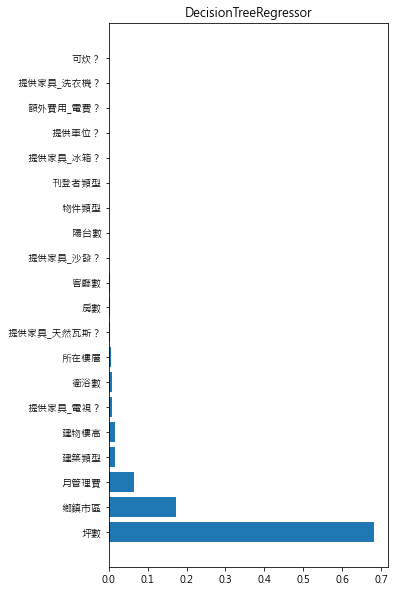

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("DecisionTreeRegressor")
#plt.barh(list(x_train.columns), clf.coef_ )

plt.barh(feature[0:20],importance[np.argsort(-abs_importance)][0:20])
# plt.show()
plt.savefig('DecisionTreeRegressor.png')
plt.show()

In [ ]:
regressor.tree_
regressor.get_depth()
regressor.get_n_leaves()
# regressor.get_params()

1000

### GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

gbdt = GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)
gbdt.fit(np.asarray(x_train), np.array(y_train,dtype=int))
y_test_pred = gbdt.predict(np.asarray(x_test))

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

importance = gbdt.feature_importances_
abs_importance = abs(importance)
feature_name = list(x_train.columns.copy())
feature = []
for i in list(np.argsort(-abs_importance)):
    feature.append(feature_name[i])

print("learningrate",0.5)
print("n_estimators",300)
print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')
# print("20 feature:",feature_name[np.argsort(-abs_importance)])
print("feature:",feature)
print("feature coef:",importance[np.argsort(-abs_importance)])

learningrate 0.5
n_estimators 300
MAE of testing set: 3511.8484606755255
RMSE of testing set: 5983.886652965397
feature: ['坪數', '鄉鎮市區', '月管理費', '衛浴數', '建築類型', '提供車位？', '提供家具_電視？', '建物樓高', '刊登者類型', '客廳數', '所在樓層', '提供家具_沙發？', '房數', '物件類型', '附近的捷運站數', '提供家具_冰箱？', '附近有_百貨公司？', '陽台數', '提供家具_天然瓦斯？', '提供家具_冷氣？', '自報頂加？', '額外費用_電費？', '提供家具_熱水器？', '可寵？', '附近的公車站數', '押金月數', '附近有_夜市？', '額外費用_網路？', '提供家具_洗衣機？', '額外費用_水費？', '提供家具_衣櫃？', '可炊？', '附近的火車站數', '提供家具_床？', '附近有_傳統市場？', '有性別限制？', '附近有_公園？', '提供家具_網路？', '提供家具_椅子？', '附近有_醫療機構？', '提供家具_桌子？', '提供家具_第四台？', '附近有_學校？', '額外費用_瓦斯？', '附近的公共自行車數（實驗中）', '額外費用_第四台？', '附近有_超商？', '附近的高鐵站數']
feature coef: [0.56531636 0.16801317 0.15772154 0.0375798  0.01374843 0.01246695
 0.00853844 0.00835916 0.00535538 0.00359401 0.00315679 0.00303784
 0.00286276 0.0018303  0.00144121 0.0010248  0.0008279  0.00069087
 0.00051318 0.00037323 0.00036352 0.00033573 0.00030715 0.00029526
 0.00025107 0.00024652 0.0002307  0.00020996 0.00019099 0.00016687
 0.0001103  0.00010994 

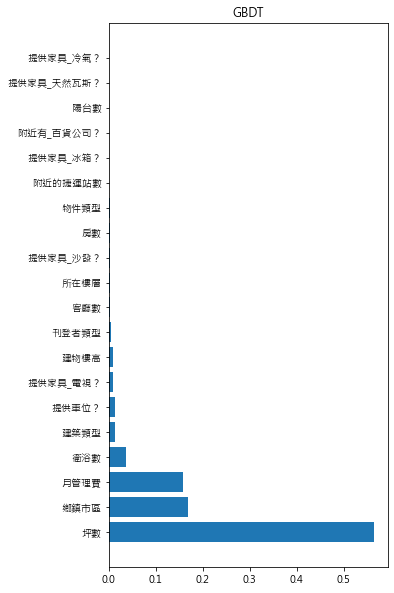

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("GBDT")
#plt.barh(list(x_train.columns), clf.coef_ )

plt.barh(feature[0:20],importance[np.argsort(-abs_importance)][0:20])
# plt.show()
plt.savefig('GBDT.png')
plt.show()

### RandomForest  - x_train

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

RandomForest = RandomForestRegressor(n_estimators=500,max_depth=40, random_state=0)
RandomForest.fit(x_train,y_train)
ypred = RandomForest.predict(x_test)
print(f'MAE of testing set: {mean_absolute_error(ypred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test))}')

# MAE of testing set: 2190.1869955871816
# RMSE of testing set: 4384.933576251044

MAE of testing set: 2172.17210525394
RMSE of testing set: 4250.750538088175


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

importance = RandomForest.feature_importances_
abs_importance = abs(importance)
feature_name = list(x_train.columns.copy())
feature = []
for i in list(np.argsort(-abs_importance)):
    feature.append(feature_name[i])

print("learningrate",0.5)
print("n_estimators",300)
print(f'MAE of testing set: {mean_absolute_error(ypred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test))}')
# print("20 feature:",feature_name[np.argsort(-abs_importance)])
print("feature:",feature)
print("feature coef:",importance[np.argsort(-abs_importance)])

# MAE of testing set: 2190.1869955871816
# RMSE of testing set: 4384.933576251044

learningrate 0.5
n_estimators 300
MAE of testing set: 2172.17210525394
RMSE of testing set: 4250.750538088175
feature: ['坪數', '鄉鎮市區', '月管理費', '建物樓高', '所在樓層', '建築類型', '衛浴數', '提供家具_電視？', '房數', '提供家具_天然瓦斯？', '陽台數', '客廳數', '刊登者類型', '附近的捷運站數', '附近的公車站數', '提供車位？', '提供家具_沙發？', '提供家具_冰箱？', '可寵？', '押金月數', '物件類型', '附近有_百貨公司？', '提供家具_洗衣機？', '附近有_夜市？', '提供家具_衣櫃？', '附近有_醫療機構？', '附近有_傳統市場？', '可炊？', '提供家具_床？', '提供家具_椅子？', '附近的火車站數', '提供家具_熱水器？', '提供家具_冷氣？', '提供家具_網路？', '額外費用_電費？', '附近有_學校？', '提供家具_第四台？', '附近有_公園？', '提供家具_桌子？', '附近有_超商？', '額外費用_水費？', '額外費用_網路？', '額外費用_第四台？', '額外費用_瓦斯？', '自報頂加？', '附近的公共自行車數（實驗中）', '有性別限制？', '附近的高鐵站數']
feature coef: [0.6291363  0.16670316 0.06619121 0.02376419 0.01641567 0.01564459
 0.00850342 0.00702034 0.00659976 0.00521719 0.00513675 0.00467317
 0.00339713 0.00312451 0.00288719 0.0025908  0.00237745 0.00219653
 0.00176499 0.00171708 0.00166984 0.001504   0.0014646  0.00123623
 0.00123317 0.00119741 0.00113298 0.00110414 0.00105036 0.00103041
 0.00097754 0.00097562 0.

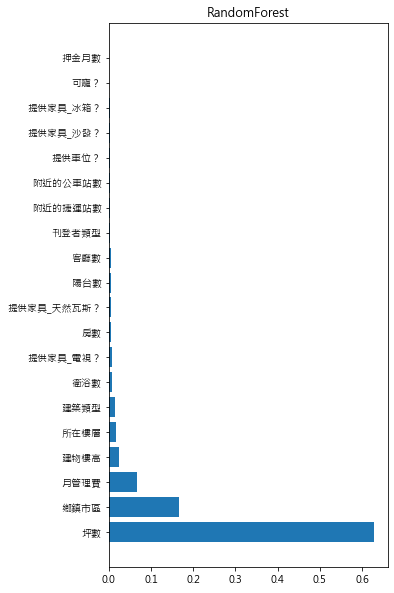

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,10))
plt.title("RandomForest")
plt.barh(feature[0:20],importance[np.argsort(-abs_importance)][0:20])
# plt.show()
plt.savefig('RandomForest.png')
plt.show()

In [ ]:
# 45度線圖
# 做出四種物件的x_test、y_test
x_test_isuite = x_test.loc[isuite_index_test]
x_test_dsuite = x_test.loc[dsuite_index_test]
x_test_room = x_test.loc[room_index_test]
x_test_floor = x_test.loc[floor_index_test]

y_test_1 = y_test.reset_index(drop=True)
y_test_isuite = y_test_1[isuite_index_test]
y_test_dsuite = y_test_1[dsuite_index_test]
y_test_room = y_test_1[room_index_test]
y_test_floor = y_test_1[floor_index_test]

y_test_pred_isuite = RandomForest.predict(np.asarray(x_test_isuite))
y_test_pred_dsuite = RandomForest.predict(np.asarray(x_test_dsuite))
y_test_pred_room = RandomForest.predict(np.asarray(x_test_room))
y_test_pred_floor = RandomForest.predict(np.asarray(x_test_floor))

# 繪圖
plt.figure(figsize=(7,7))
plt.scatter(y_test_isuite, y_test_pred_isuite, alpha=0.4, color='red', label="獨立套房")
plt.scatter(y_test_dsuite, y_test_pred_dsuite, alpha=0.3, color='blue', label="分租套房")
plt.scatter(y_test_room, y_test_pred_room, alpha=0.2, color='green', label="雅房")
plt.scatter(y_test_floor, y_test_pred_floor, alpha=0.1, color='yellow', label="整層住家")
plt.axline([min(y_test), min(y_test)], [max(y_test), max(y_test)], color='r')

plt.xlim(min(y_test), max(y_test))
plt.ylim(min(y_test), max(y_test))

plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_test_pred", fontsize=15)
plt.title("Random forest, Y vs Y-hat", fontsize=15)
plt.legend(fontsize=15)
plt.show()

### SVM

In [ ]:
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
regr = svm.SVR()
regr.fit(x_train, y_train)

y_test_pred = regr.predict(x_test)

print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')
y_compare = pd.DataFrame({'y_pred': y_test_pred,'y_true': y_test})
y_compare
#10900~11000多
# MAE of testing set: 9208.624275746668
# RMSE of testing set: 15995.26079452831

MAE of testing set: 9246.407047768425
RMSE of testing set: 16074.497977505058


,y_pred,y_true
97205,26627.30,23500
674857,13008.05,5000
413487,13001.83,7000
104973,14591.74,14000
698905,22351.26,22000
...,...,...
109782,14547.39,26000
574194,13023.16,20000
524433,13001.43,5500
469983,13002.92,6000


### SGD Regressor

In [ ]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Always scale the input. The most convenient way is to use a pipeline.
SGD = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=4000, tol=1e-6))
SGD.fit(x_train, y_train)

y_test_pred = SGD.predict(x_test)

print(f'MAE of testing set: {mean_absolute_error(y_test_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(y_test_pred, y_test))}')
y_compare = pd.DataFrame({'y_pred': y_test_pred,'y_true': y_test})
y_compare
# MAE of testing set: 5631.368049121293
# RMSE of testing set: 9072.167479636231

MAE of testing set: 5434.686987994416
RMSE of testing set: 8942.29927991686


,y_pred,y_true
97205,27389.47,23500
674857,3075.08,5000
413487,5079.13,7000
104973,17955.94,14000
698905,25799.66,22000
...,...,...
109782,22893.87,26000
574194,23624.55,20000
524433,14425.29,5500
469983,6843.76,6000


### Stacking

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

estimators = [
    ('gbdt', GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)),
    ('DecisionTree', DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20))
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack.fit(x_train, y_train).score(x_test, y_test)

ypred = stack.predict(x_test)
print(f'MAE of testing set: {mean_absolute_error(ypred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test))}')

# MAE of testing set: 3781.9756252476686
# RMSE of testing set: 6370.388475594114

MAE of testing set: 3751.5288584833256
RMSE of testing set: 6286.727278201863


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

estimators = [
    ('gbdt', GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)),
    ('DecisionTree', DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)),
    ('RandomForestRegressor',RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0))
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack.fit(x_train, y_train).score(x_test, y_test)

ypred = stack.predict(x_test)
print(f'MAE of testing set: {mean_absolute_error(ypred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test))}')

# MAE of testing set: 2359.7154011526254
# RMSE of testing set: 4420.554970502002

MAE of testing set: 2359.7154011526254
RMSE of testing set: 4420.554970502002


### 測試集的不同類別(套房/雅房/整層等)物件各跑一次MAE個別評估結果

#### (1)取獨立套房的資料

In [ ]:
df_test = df2.copy()
df_test = df_test.loc[(df_test['物件類型']==1)]
df_test_x = df_test[features].copy()
df_test_y = df_test['月租金']

df_test_x, df_test_y = preprocess(df_test_x, df_test_y)
from sklearn.model_selection import train_test_split

x_train_isuite, x_test_isuite, y_train_isuite, y_test_isuite = train_test_split( df_test_x, df_test_y, test_size=0.25, random_state=4)

x_train_isuite = x_train_isuite.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test_isuite = x_test_isuite.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)

共有0筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了
共有0筆資料房數是0的，所以先刪了
共有0筆資料衛浴數是0的，所以先刪了


<ipython-input-28-f01f67baec05>:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in x.values:


#### (2)取分租套房的資料

In [ ]:
df_test = df2.copy()
df_test = df_test.loc[(df_test['物件類型']==2)]
df_test_x = df_test[features].copy()
df_test_y = df_test['月租金']
df_test_x, df_test_y = preprocess(df_test_x, df_test_y)
from sklearn.model_selection import train_test_split

x_train_dsuite, x_test_dsuite, y_train_dsuite, y_test_dsuite = train_test_split( df_test_x, df_test_y, test_size=0.25, random_state=4)

x_train_dsuite = x_train_dsuite.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test_dsuite = x_test_dsuite.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)

print(x_train_dsuite.shape)
print(x_test_dsuite.shape)

共有0筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了
共有0筆資料房數是0的，所以先刪了
共有0筆資料衛浴數是0的，所以先刪了
(54946, 48)
(18316, 48)


<ipython-input-28-f01f67baec05>:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in x.values:


#### (3)取雅房的資料

In [ ]:
df_test = df2.copy()
df_test = df_test.loc[(df_test['物件類型']==3)]
df_test_x = df_test[features].copy()
df_test_y = df_test['月租金']
df_test_x, df_test_y = preprocess(df_test_x, df_test_y)
from sklearn.model_selection import train_test_split

x_train_room, x_test_room, y_train_room, y_test_room = train_test_split( df_test_x, df_test_y, test_size=0.25, random_state=4)

x_train_room = x_train_room.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test_room = x_test_room.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)

print(x_train_room.shape)
print(x_test_room.shape)

共有0筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了
共有0筆資料房數是0的，所以先刪了
共有0筆資料衛浴數是0的，所以先刪了
(21754, 48)
(7252, 48)


<ipython-input-28-f01f67baec05>:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in x.values:


#### (4)取整層住家的資料

In [ ]:
df_test = df2.copy()
df_test = df_test.loc[(df_test['物件類型']==0)]
df_test_x = df_test[features].copy()
df_test_y = df_test['月租金']
df_test_x, df_test_y = preprocess(df_test_x, df_test_y)

from sklearn.model_selection import train_test_split

x_train_floor, x_test_floor, y_train_floor, y_test_floor = train_test_split( df_test_x, df_test_y, test_size=0.25, random_state=4)

x_train_floor = x_train_floor.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)
x_test_floor = x_test_floor.drop(['縣市', '重複物件數','需要管理費？'], axis = 1)


print(x_train_floor.shape)
print(x_test_floor.shape)


共有48筆資料是非獨立套房、分租套房、雅房又是空值的，所以先刪了
共有4144筆資料房數是0的，所以先刪了
共有310筆資料衛浴數是0的，所以先刪了
(191382, 48)
(63794, 48)


<ipython-input-28-f01f67baec05>:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in x.values:


### 分開 predict model

#### (1) RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

RandomForest1 = RandomForestRegressor(n_estimators=500,max_depth=40, random_state=0)
RandomForest1.fit(x_train_isuite,y_train_isuite)
ypred = RandomForest1.predict(x_test_isuite)
print(f'獨立套房 MAE of testing set: {mean_absolute_error(ypred, y_test_isuite)}')
print(f'獨立套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_isuite))}')
print()

RandomForest2 = RandomForestRegressor(n_estimators=500,max_depth=40, random_state=0)
RandomForest2.fit(x_train_dsuite,y_train_dsuite)
ypred = RandomForest2.predict(x_test_dsuite)
print(f'分租套房 MAE of testing set: {mean_absolute_error(ypred, y_test_dsuite)}')
print(f'分租套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_dsuite))}')
print()

RandomForest3 = RandomForestRegressor(n_estimators=500,max_depth=40, random_state=0)
RandomForest3.fit(x_train_room,y_train_room)
ypred = RandomForest3.predict(x_test_room)
print(f'雅房 MAE of testing set: {mean_absolute_error(ypred, y_test_room)}')
print(f'雅房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_room))}')
print()

RandomForest4 = RandomForestRegressor(n_estimators=500,max_depth=40, random_state=0)
RandomForest4.fit(x_train_floor,y_train_floor)
ypred = RandomForest4.predict(x_test_floor)
print(f'整層住家 MAE of testing set: {mean_absolute_error(ypred, y_test_floor)}')
print(f'整層住家 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_floor))}')


獨立套房 MAE of testing set: 1373.301114155991
獨立套房 RMSE of testing set: 2334.70121285854

分租套房 MAE of testing set: 1071.3115245969018
分租套房 RMSE of testing set: 1986.8929179134543

雅房 MAE of testing set: 802.3474349725365
雅房 RMSE of testing set: 1526.1812590950747

整層住家 MAE of testing set: 3122.503363266859
整層住家 RMSE of testing set: 5598.64649898067


#### (2) GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

gbdt1 = GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)
gbdt1.fit(np.asarray(x_train_isuite), np.array(y_train_isuite,dtype=int))
ypred = gbdt1.predict(np.asarray(x_test_isuite))
print(f'獨立套房 MAE of testing set: {mean_absolute_error(ypred, y_test_isuite)}')
print(f'獨立套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_isuite))}')
print()

gbdt2 = GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)
gbdt2.fit(np.asarray(x_train_dsuite), np.array(y_train_dsuite,dtype=int))
ypred = gbdt2.predict(np.asarray(x_test_dsuite))
print(f'分租套房 MAE of testing set: {mean_absolute_error(ypred, y_test_dsuite)}')
print(f'分租套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_dsuite))}')
print()

gbdt3 = GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)
gbdt3.fit(np.asarray(x_train_room), np.array(y_train_room,dtype=int))
ypred = gbdt3.predict(np.asarray(x_test_room))
print(f'雅房 MAE of testing set: {mean_absolute_error(ypred, y_test_room)}')
print(f'雅房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_room))}')
print()

gbdt4 = GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)
gbdt4.fit(np.asarray(x_train_floor), np.array(y_train_floor,dtype=int))
ypred = gbdt4.predict(np.asarray(x_test_floor))
print(f'整層住家 MAE of testing set: {mean_absolute_error(ypred, y_test_floor)}')
print(f'整層住家 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_floor))}')

# 獨立套房 MAE of testing set: 2228.258273977195
# 獨立套房 RMSE of testing set: 3279.274880866625

# 分租套房 MAE of testing set: 1735.6281226920128
# 分租套房 RMSE of testing set: 2690.752461395302

# 雅房 MAE of testing set: 1521.7064469184386
# 雅房 RMSE of testing set: 2170.163019910545

# 整層住家 MAE of testing set: 5238.822439047376
# 整層住家 RMSE of testing set: 8418.7813352285

獨立套房 MAE of testing set: 1966.164148520179
獨立套房 RMSE of testing set: 2921.105489387327

分租套房 MAE of testing set: 1476.0930670748876
分租套房 RMSE of testing set: 2333.1382786416034

雅房 MAE of testing set: 1082.475865183091
雅房 RMSE of testing set: 1759.646229167903

整層住家 MAE of testing set: 5010.385083084188
整層住家 RMSE of testing set: 7850.281439691422


#### (3) Decision tree 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor1 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)
regressor1.fit(np.asarray(x_train_isuite), y_train_isuite)
ypred = regressor1.predict(np.asarray(x_test_isuite))
print(f'獨立套房 MAE of testing set: {mean_absolute_error(ypred, y_test_isuite)}')
print(f'獨立套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_isuite))}')
print()

regressor2 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)
regressor2.fit(np.asarray(x_train_dsuite), y_train_dsuite)
ypred = regressor2.predict(np.asarray(x_test_dsuite))
print(f'分租套房 MAE of testing set: {mean_absolute_error(ypred, y_test_dsuite)}')
print(f'分租套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_dsuite))}')
print()

regressor3 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)
regressor3.fit(np.asarray(x_train_room), y_train_room)
ypred = regressor3.predict(np.asarray(x_test_room))
print(f'雅房 MAE of testing set: {mean_absolute_error(ypred, y_test_room)}')
print(f'雅房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_room))}')
print()

regressor4 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)
regressor4.fit(np.asarray(x_train_floor), y_train_floor)
ypred = regressor4.predict(np.asarray(x_test_floor))
print(f'整層住家 MAE of testing set: {mean_absolute_error(ypred, y_test_floor)}')
print(f'整層住家 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_floor))}')

# 獨立套房 MAE of testing set: 2532.696599537837
# 獨立套房 RMSE of testing set: 3719.2403688707777

# 分租套房 MAE of testing set: 1896.3720492687366
# 分租套房 RMSE of testing set: 2837.1603821358012

# 雅房 MAE of testing set: 1692.7866770392511
# 雅房 RMSE of testing set: 2631.832753744811

# 整層住家 MAE of testing set: 6008.1963630324535
# 整層住家 RMSE of testing set: 9694.452996412705

獨立套房 MAE of testing set: 2131.953173154521
獨立套房 RMSE of testing set: 3284.003874557041

分租套房 MAE of testing set: 1600.4671013627535
分租套房 RMSE of testing set: 2657.2857498946364

雅房 MAE of testing set: 1175.1370814201011
雅房 RMSE of testing set: 2004.4892345574926

整層住家 MAE of testing set: 5583.076168707064
整層住家 RMSE of testing set: 8629.827434388397


#### (4) Stacking

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

estimators = [
    ('gbdt', GradientBoostingRegressor(learning_rate=0.5,n_estimators=300,random_state=0)),
    ('DecisionTree', DecisionTreeRegressor(random_state=0, max_leaf_nodes=1000, max_depth=20)),
    ('RandomForest',RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0))
]
stack1 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack1.fit(x_train_isuite, y_train_isuite).score(x_test_isuite, y_test_isuite)
ypred = stack1.predict(x_test_isuite)
print(f'獨立套房 MAE of testing set: {mean_absolute_error(ypred, y_test_isuite)}')
print(f'獨立套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_isuite))}')
print()

stack2 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack2.fit(x_train_dsuite, y_train_dsuite).score(x_test_dsuite, y_test_dsuite)
ypred = stack2.predict(x_test_dsuite)
print(f'分租套房 MAE of testing set: {mean_absolute_error(ypred, y_test_dsuite)}')
print(f'分租套房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_dsuite))}')
print()

stack3 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack3.fit(x_train_room, y_train_room).score(x_test_room, y_test_room)
ypred = stack3.predict(x_test_room)
print(f'雅房 MAE of testing set: {mean_absolute_error(ypred, y_test_room)}')
print(f'雅房 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_room))}')
print()

stack4 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500,max_depth=400, random_state=0)
)
stack4.fit(x_train_floor, y_train_floor).score(x_test_floor, y_test_floor)
ypred = stack4.predict(x_test_floor)
print(f'整層住家 MAE of testing set: {mean_absolute_error(ypred, y_test_floor)}')
print(f'整層住家 RMSE of testing set: {np.sqrt(mean_squared_error(ypred, y_test_floor))}')


# 獨立套房 MAE of testing set: 2152.3282446689186
# 獨立套房 RMSE of testing set: 3249.0279399443484

# 分租套房 MAE of testing set: 1597.4550338319723
# 分租套房 RMSE of testing set: 2524.2556031438844

# 雅房 MAE of testing set: 1164.2565409378433
# 雅房 RMSE of testing set: 1881.4469498313533

# 整層住家 MAE of testing set: 5347.039173330033
# 整層住家 RMSE of testing set: 8207.296364421618

獨立套房 MAE of testing set: 1490.5684007508394
獨立套房 RMSE of testing set: 2432.4516919252005

分租套房 MAE of testing set: 1156.0967167648412
分租套房 RMSE of testing set: 2094.9939609312983

雅房 MAE of testing set: 885.6089709264957
雅房 RMSE of testing set: 1635.331230837897

整層住家 MAE of testing set: 3399.298185696834
整層住家 RMSE of testing set: 5856.393718690391


### 中位數(baseline)的MAE與RMSE

In [ ]:
df_baseline = pd.concat([x_train[['物件類型']], y_train], axis = 1)
baseline = df_baseline.groupby('物件類型').median()
baseline
x_test.loc[x_test['物件類型'] == 0, '預測值'] = 20000 #補個baseline_y_pred值，要改
x_test.loc[x_test['物件類型'] == 1, '預測值'] = 20499
x_test.loc[x_test['物件類型'] == 2, '預測值'] = 20999
x_test.loc[x_test['物件類型'] == 3, '預測值'] = 20500
baseline_y_pred = x_test[['預測值']]

x_test = x_test.drop(['預測值'], axis = 1)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(f'MAE of testing set: {mean_absolute_error(baseline_y_pred, y_test)}')
print(f'RMSE of testing set: {np.sqrt(mean_squared_error(baseline_y_pred, y_test))}')


MAE of testing set: 12500.499855462747
RMSE of testing set: 19020.946336109053
